In [2]:
# compatibility with Python 2
from __future__ import print_function

# preprocess
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.preprocessing import MinMaxScaler

# To import the classifier (SVM classifier)
from sklearn.svm import SVC

# To measure accuracy
from sklearn import metrics
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV

# computes distance between each pair of two collections of inputs
from scipy.spatial.distance import pdist

# repaired matrix by averaging; probably the best can do without domain-specific information
from sklearn.utils.validation import check_symmetric

# clustering-related methods
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
from sklearn.metrics import silhouette_score 

# dimensionality reduction
from sklearn.decomposition import PCA

# support plots
from ipywidgets import interact
import ipywidgets as widgets
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm

import seaborn as sns; sns.set()
import networkx as nx

import numpy as np
import pandas as pd
import math

# To increase quality of figures
plt.rcParams["figure.figsize"] = (20, 7)

# display all the plots inline
%matplotlib inline

# fs-related operations
import os

# download files
import requests

#float_formatter = lambda x: "%.3f" % x
#np.set_printoptions(formatter={'float_kind':float_formatter})

In [3]:
# To import the scalers
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Binarizer


class DummyScaler:
    
    def fit(self, data):
        pass
    
    def transform(self, data):
        return data

def create_scaler_dummy():
    return DummyScaler()
    
def create_scaler_standard():
    return StandardScaler()

def create_scaler_minmax():
    return MinMaxScaler()

def crete_scaler_binarizer():
    return Binarizer()

In [4]:
data = pd.read_excel('../c/data.xlsx') 
image = pd.read_excel('../c/image.xlsx')

In [5]:
print(data.shape)
data.head(5)

(4426, 8)


,GlobalID,Detection Date,Notes,Lab Status,Lab Comments,Submission Date,Latitude,Longitude
0,{5AC8034E-5B46-4294-85F0-5B13117EBEFE},2019-12-08,"One dead wasp seen in Blaine, and suspect flyi...",Positive ID,,2020-01-15,48.980994,-122.688503
1,{5EAD3364-2CA7-4A39-9A53-7F9DCF5D2041},2019-10-30,Hornet specimen sent to WSU,Positive ID,,2020-01-15,48.971949,-122.700941
2,{13B67BCB-AFCE-4100-AD2B-76EF178BA228},2020-01-15,"Massive loss of bees, decapitated. No hornet s...",Unverified,,2020-01-15,48.939200,-122.661300
3,{124B9BFA-7F7B-4B8E-8A56-42E067F0F72E},2019-09-19,This was the colony that was found and destroy...,Positive ID,"Thanks for adding this, and the great pictures!",2020-02-04,49.149394,-123.943134
4,{BBBA5BA0-CAFB-43D3-8F1D-FB2D9CF777E0},2019-08-31,I was cleaning my gutters when I heard a snapp...,Unverified,Thanks for this report. I can't verify it from...,2020-02-14,48.723779,-122.354431


In [6]:
print(image.shape)
image.head(5)

(3305, 3)


,FileName,GlobalID,FileType
0,ATT1_DSCN9647.jpg,{5AC8034E-5B46-4294-85F0-5B13117EBEFE},image/jpg
1,ATT10_67EAF187-B59C-4F5F-BAAC-9F76E06A96D6.jpg,{C4F44511-EA53-4FCF-9422-E1C57703720D},image/jpg
2,ATT100_inbound241937372812029587.jpg,{43506835-18B8-46B2-A2CB-586AF9C8ECE6},image/jpg
3,ATT1000_A5A50BAB-A6EF-4576-A1F8-A07862AADE3A.jpg,{E0AE2F2A-38A5-463C-97B5-9F84A477F9AE},image/jpg
4,ATT1001_8B9F8599-61EF-4690-B195-888BCD319F32.png,{1CD14B56-4046-44C4-B1B8-8FB07A9071E9},image/png


# Q1 + Q3

Address and discuss whether or not the spread of this pest over time can be predicted, and with what level of precision.

Use your model to discuss how your classification analyses leads to prioritizing investigation of the reports most likely to be positive sightings.

# Step 0: Preprocess

In [7]:
# significant imbalanced sample
data['Lab Status'].value_counts()

Unverified     2329
Negative ID    2068
Unprocessed      15
Positive ID      14
Name: Lab Status, dtype: int64

In [8]:
# adding label as a new column to data
# assign class 0 to the negative id in [lab status], class 1 to positive
# class 0 and 1 are training set, the rest is test set

data['label']= -1
data.loc[data['Lab Status'] == 'Positive ID', 'label'] = 1
data.loc[data['Lab Status'] == 'Negative ID', 'label'] = 0
data

,GlobalID,Detection Date,Notes,Lab Status,Lab Comments,Submission Date,Latitude,Longitude,label
0,{5AC8034E-5B46-4294-85F0-5B13117EBEFE},2019-12-08,"One dead wasp seen in Blaine, and suspect flyi...",Positive ID,,2020-01-15,48.980994,-122.688503,1
1,{5EAD3364-2CA7-4A39-9A53-7F9DCF5D2041},2019-10-30,Hornet specimen sent to WSU,Positive ID,,2020-01-15,48.971949,-122.700941,1
2,{13B67BCB-AFCE-4100-AD2B-76EF178BA228},2020-01-15,"Massive loss of bees, decapitated. No hornet s...",Unverified,,2020-01-15,48.939200,-122.661300,-1
3,{124B9BFA-7F7B-4B8E-8A56-42E067F0F72E},2019-09-19,This was the colony that was found and destroy...,Positive ID,"Thanks for adding this, and the great pictures!",2020-02-04,49.149394,-123.943134,1
4,{BBBA5BA0-CAFB-43D3-8F1D-FB2D9CF777E0},2019-08-31,I was cleaning my gutters when I heard a snapp...,Unverified,Thanks for this report. I can't verify it from...,2020-02-14,48.723779,-122.354431,-1
...,...,...,...,...,...,...,...,...,...
4421,{153C4ACC-72AE-4D87-AA80-4C714417F8C6},2020-10-02,It was about an inch and a quarter in length. ...,Unprocessed,,2020-10-23,47.145673,-122.566734,-1
4422,{26DDF8E2-DA0C-4F87-A65A-233115BAFCCD},2020-08-29,I was stung several times on the 7th hole ov t...,Unprocessed,,2020-10-23,48.997938,-122.729890,-1
4423,{3E50801D-9DBB-43DE-8D32-31CFA88C74D9},2020-10-23,Found dead in humming bird feeder. Silverdale WA,Unprocessed,,2020-10-23,47.651710,-122.692750,-1
4424,{9BA7BDD9-01A5-4776-99B0-89FCE08CA53B},2020-10-19,I live on Bainbridge Island on a heavily woode...,Unprocessed,,2020-10-23,47.690120,-122.509780,-1


In [9]:
# posID = data.loc[data['Lab Status'] == 'Positive ID', 'GlobalID']
# negaID = data.loc[data['Lab Status'] == 'Negative ID', 'GlobalID']
# unverID = data.loc[data['Lab Status'] == 'Unverified', 'GlobalID']
# unpID = data.loc[data['Lab Status'] == 'Unprocessed', 'GlobalID']

# posID.to_csv('../mcm-c/PositiveGlobalID.csv')
# negaID.to_csv('../mcm-c/NegativeGlobalID.csv')
# unverID.to_csv('../mcm-c/UnverifiedGlobalID.csv')
# unpID.to_csv('../mcm-c/UnprocessedGlobalID.csv')

In [10]:
# # give the pictures tags based on GlobalID
# pID = posID.values.tolist()
# nID = negaID.values.tolist()
# uvID = unverID.values.tolist()
# upID = unpID.values.tolist()

# kind_id = 0
# def find_kind(x):
#     kind = []
#     for i in x:
#         if i in pID:
#             kind_id = 'positive'
#             kind.appand(kind_id)
#         elif i in nID:
#             kind_id = 'negative'
#             kind.appand(kind_id)
#         elif i in uvID:
#             kind_id = 'unverified'
#             kind.appand(kind_id)
#         elif i in upID:
#             kind_id = 'unprocessed'
#             kind.appand(kind_id)
#         else:
#             kind_id = 'NA'
#             kind.appand(kind_id)
        
#     return kind_id
# #image['kind'] = find_kind(image.loc[image['GlobalID']].values)

In [11]:
# seperate unknown data for later
unknown_pic = data.loc[data['label']== -1]

# remove all the missing / irrelevent values
# data = data[data.label != -1]
data = data.drop('GlobalID', axis = 1)
data = data.drop('Notes', axis = 1)
data = data.drop('Lab Status', axis = 1)
data = data.drop('Submission Date', axis = 1)
data = data.drop('Lab Comments', axis = 1)

In [12]:
data.columns = ['date','lat', 'lon', 'class']
type(data.date[1])

pandas._libs.tslibs.timestamps.Timestamp

In [13]:
data = data[data.date != 0]
data = data[data.lat != 0]
data = data[data.lon != 0]
data

,date,lat,lon,class
0,2019-12-08,48.980994,-122.688503,1
1,2019-10-30,48.971949,-122.700941,1
2,2020-01-15,48.939200,-122.661300,-1
3,2019-09-19,49.149394,-123.943134,1
4,2019-08-31,48.723779,-122.354431,-1
...,...,...,...,...
4421,2020-10-02,47.145673,-122.566734,-1
4422,2020-08-29,48.997938,-122.729890,-1
4423,2020-10-23,47.651710,-122.692750,-1
4424,2020-10-19,47.690120,-122.509780,-1


In [14]:
# change datetime type into integers
from datetime import datetime
data['date'] = data['date'].astype(str)

In [15]:
type(data.date[3])

str

In [16]:
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')

In [18]:
# Manually delete case with the abnormal date causing error, already done
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data.head()

,date,lat,lon,class
0,2019-12-08,48.980994,-122.688503,1
1,2019-10-30,48.971949,-122.700941,1
2,2020-01-15,48.939200,-122.661300,-1
3,2019-09-19,49.149394,-123.943134,1
4,2019-08-31,48.723779,-122.354431,-1


In [19]:
type(data.date[3])

pandas._libs.tslibs.timestamps.Timestamp

In [20]:
data['date'] = data['date'].apply(datetime.toordinal)

In [21]:
data

,date,lat,lon,class
0,737401,48.980994,-122.688503,1
1,737362,48.971949,-122.700941,1
2,737439,48.939200,-122.661300,-1
3,737321,49.149394,-123.943134,1
4,737302,48.723779,-122.354431,-1
...,...,...,...,...
4421,737700,47.145673,-122.566734,-1
4422,737666,48.997938,-122.729890,-1
4423,737721,47.651710,-122.692750,-1
4424,737717,47.690120,-122.509780,-1


In [22]:
type(data.date[3])

numpy.int64

# Step 1: K-Means clustering

In [33]:
# preprocess data for clustering

X = data.drop(['class'], axis = 1)
X = StandardScaler().fit_transform(data)
X

array([[-0.56829414,  1.88587175, -0.61612345,  3.01907901],
       [-0.68455867,  1.87331023, -0.6246394 ,  3.01907901],
       [-0.45501075,  1.82782908, -0.59749833, -0.93664737],
       ...,
       [ 0.38567125,  0.03978892, -0.61903125, -0.93664737],
       [ 0.37374668,  0.09313195, -0.4937569 , -0.93664737],
       [ 0.1471799 , -2.29714565, -0.40939304, -0.93664737]])

In [34]:
# use PCA (principal component analysis) to reduce dimension to 2 to simply visualize the data

pca_model = PCA(n_components=2)
X_reduced = pca_model.fit_transform(X)

In [35]:
# Here we use closure to store the related variables

def create_plot_kmeans_digits(_X, _y, _n_classes):
    X, y = _X, _y
    n_classes = _n_classes
    colors = np.array([cm.tab20(i) for i in range(100)])

# set K randomly for initialisation

    def plot_kmeans_digits(n_clusters=10):
        expand=1
        kmeans = KMeans(init='k-means++', n_clusters=n_clusters, n_init=10, random_state=520, max_iter=1000, n_jobs=-1)
        kmeans.fit(X)
        y_predicted = kmeans.predict(X)
        fig, (ax1, ax2) = plt.subplots(1, 2)
        ax1.plot((np.min(X_reduced[:, 0])-expand, np.max(X_reduced[:, 0])+expand), 
                 (np.min(X_reduced[:, 1])-expand, np.max(X_reduced[:, 1])+expand),
                 alpha=0.0)
        xlim = ax1.get_xlim()
        ylim = ax1.get_ylim()
        ax1.scatter(X_reduced[:, 0], X_reduced[:, 1], c=colors[y_predicted])
        ax1.set_xlabel('pca #1')
        ax1.set_ylabel('pca #2') 
        centers = np.array(kmeans.cluster_centers_)
        ax1.scatter(centers[:, 0], centers[:, 1], marker="x", color='k', s=64)
        matrix = np.zeros((n_clusters, n_classes))
        for cluster in range(n_clusters):
            for cl in range(n_classes):
                matrix[cluster, cl] = np.sum(y[y_predicted == cluster]==cl)
        sns.heatmap(matrix, annot=True, fmt='g', ax=ax2)
        ax2.set_xlabel('Class')
        ax2.set_ylabel('Cluster')
        print('Inertia:', kmeans.inertia_)
        plt.show()
    return plot_kmeans_digits

In [65]:
# To increase quality of figures
plt.rcParams["figure.figsize"] = (25, 10)

In [66]:
n_clusters_widget = widgets.IntSlider(
    value=1,
    min=1,
    max=20,
    step=1,
    continuous_update=False,
    description='N clusters:')
interact(create_plot_kmeans_digits(X_reduced, y_predicted, 10),
         n_clusters=n_clusters_widget)

interactive(children=(IntSlider(value=1, continuous_update=False, description='N clusters:', max=20, min=1), O…

<function __main__.create_plot_kmeans_digits.<locals>.plot_kmeans_digits(n_clusters=10)>

In [45]:
# If class labels are not available, within-cluster sum of squares (inertia) can be used
# inertia: how far away the points within a cluster are，the smaller the better

n_clusters = range(1, 30)
inertia = np.zeros(len(n_clusters))
for i, clusters in enumerate(n_clusters):
    kmeans = KMeans(init='k-means++', n_clusters=clusters, n_init=10, random_state=520, max_iter=1000, n_jobs=-1)
    kmeans.fit(X)
    inertia[i] = kmeans.inertia_
    y_predicted = kmeans.predict(X)

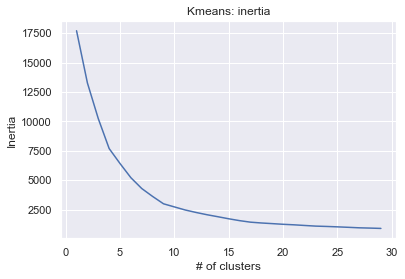

In [46]:
plt.plot(n_clusters, inertia)
plt.title('Kmeans: inertia')
plt.xlabel('# of clusters')
plt.ylabel('Inertia')
plt.show()

In [47]:
# so the number of clusters choosen can be 5 to 10
# try for 10

k_means = KMeans(n_clusters=10)

#Run the clustering algorithm
model = k_means.fit(X)
model

#Generate cluster predictions and store in y_hat
y_hat = k_means.predict(X)

labels = k_means.labels_

# Calculating the silhouette coefficient
print(metrics.silhouette_score(X, labels, metric = 'euclidean'))

# CH score
print(metrics.calinski_harabasz_score(X, labels))

0.49094230020699553
2700.55300151564


In [48]:
# try for other number of clusters (=8)
k_means_8 = KMeans(n_clusters=8)
model = k_means_8.fit(X)
y_hat_8 = k_means_8.predict(X)
labels_8 = k_means_8.labels_
print(metrics.silhouette_score(X, labels_8, metric = 'euclidean'))
print(metrics.calinski_harabasz_score(X, labels_8))

0.4879590790075683
2464.320770822012


In [49]:
# try for other number of clusters (=5)
k_means_5 = KMeans(n_clusters=5)
model = k_means_5.fit(X)
y_hat_5 = k_means_5.predict(X)
labels_5 = k_means_5.labels_
print(metrics.silhouette_score(X, labels_5, metric = 'euclidean'))
print(metrics.calinski_harabasz_score(X, labels_5))

0.4796933072500037
1947.3229935272184


In [50]:
# try for other number of clusters (=15)
k_means_15 = KMeans(n_clusters=15)
model = k_means_15.fit(X)
y_hat_15 = k_means_15.predict(X)
labels_15 = k_means_15.labels_
print(metrics.silhouette_score(X, labels_15, metric = 'euclidean'))
print(metrics.calinski_harabasz_score(X, labels_15))

0.4669041010254173
2939.547783240921


In [51]:
# finally choose n_clusters = 10, add label to the original dataframe

data['KmeansCluster'] = labels
data.head()

,date,lat,lon,class,KmeansCluster
0,737401,48.980994,-122.688503,1,5
1,737362,48.971949,-122.700941,1,5
2,737439,48.939200,-122.661300,-1,2
3,737321,49.149394,-123.943134,1,5
4,737302,48.723779,-122.354431,-1,2


In [52]:
data.to_csv('../clusteredData.csv')

# Step 2 : Class_Weighted SVM - RBF

In [ ]:
# drop the class = -1 points 

In [53]:
# find classifer for each cluster
# store each cluster into sub dataset (dataframe)
sub0 = data.loc[data['KmeansCluster'] == 0]
sub1 = data.loc[data['KmeansCluster'] == 1]
sub2 = data.loc[data['KmeansCluster'] == 2]
sub3 = data.loc[data['KmeansCluster'] == 3]
sub4 = data.loc[data['KmeansCluster'] == 4]
sub5 = data.loc[data['KmeansCluster'] == 5]
sub6 = data.loc[data['KmeansCluster'] == 6]
sub7 = data.loc[data['KmeansCluster'] == 7]
sub8 = data.loc[data['KmeansCluster'] == 8]
sub9 = data.loc[data['KmeansCluster'] == 9]

In [134]:
# split to X and y
# X is all the features' data, y is all the class data
vals = data.values
X = vals[:, :-1]
y = vals[:, -1]

In [139]:
# split the data into train and test set（10%）randomly
# scale the data before using SVM

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=500)

create_scaler = create_scaler_minmax
scaler = create_scaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [157]:
# Hyperparameter search (rbf)
# apply cross validation

model = RandomizedSearchCV(SVC(kernel='rbf', random_state=520),
                           cv=5,
                           n_iter=40,
                           n_jobs=-1,
                           iid=False,
                           param_distributions={
                               'C': [10**x for x in range(-3, 4)], 
                               'gamma': [10**x for x in range(-3, 4)]
                           })

# model = GridSearchCV(SVC(kernel='rbf', random_state=520),
#                          cv=5,
#                          n_jobs=-1,
#                          iid=False,
#                          param_grid={
#                              'C': [10**x for x in range(-3, 4)], 
#                              'gamma': [10**x for x in range(-3, 4)]
#                          })

model.fit(X_train, y_train)
print('Optimal parameters:', model.best_params_)

y_test_hat = model.predict(X_test)
print('Accuracy:', metrics.accuracy_score(y_test, y_test_hat))

print(metrics.classification_report(y_test, y_test_hat))

Optimal parameters: {'gamma': 1000, 'C': 10}
Accuracy: 1.0
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       209

    accuracy                           1.00       209
   macro avg       1.00      1.00      1.00       209
weighted avg       1.00      1.00      1.00       209



In [154]:
# Support Vector Machines Classifier (RBF)
# using weighted classes, sklearn automatically generates the weight

def create_plot_svm_classification_rbf(_X, _y):
    X, y = _X, _y
    def plot_svc_rbf(C=1, gamma=1, expand=0, intensity=0.1):
        clf = SVC(kernel='rbf', C=C, gamma=gamma, class_weight='balanced')
        clf.fit(X, y)
        fig, ax = plt.subplots()
        ax.plot((np.min(X[:, 0])-expand, np.max(X[:, 0])+expand), (np.min(X[:, 1])-expand, np.max(X[:, 1])+expand), alpha=0.0)
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        xx = np.linspace(xlim[0], xlim[1], 400)
        yy = np.linspace(ylim[0], ylim[1], 200)
        YY, XX = np.meshgrid(yy, xx)
        xy = np.vstack([XX.ravel(), YY.ravel()]).T
        Z = clf.decision_function(xy).reshape(XX.shape)
        v = max(-np.min(Z), np.max(Z))
        cf = ax.contourf(XX, YY, Z, 100, cmap='coolwarm', norm = mpl.colors.Normalize(vmin=-v, vmax=v), alpha=intensity)
        ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.bwr)
        ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.8,
                   linestyles=['--', '-', '--'], linewidths=[2, 5, 2])
        ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
                   linewidth=1, facecolors='none', edgecolors='k')
        plt.xlabel('Sepal width')
        plt.ylabel('Petal length')
        plt.title('Support Vector Machines Classifier: C=%s, Gamma=%s.' % (str(C), str(gamma)))
        plt.show()
    return plot_svc_rbf

interactive(children=(FloatLogSlider(value=10.0, continuous_update=False, description='C:', max=3.0, min=-4.0,…

<function __main__.create_plot_svm_classification_rbf.<locals>.plot_svc_rbf(C=1, gamma=1, expand=0, intensity=0.1)>

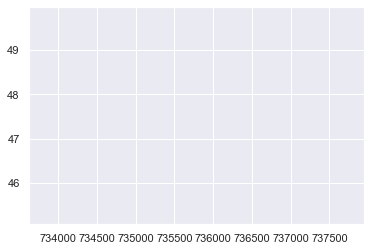

In [155]:
С_widget = widgets.FloatLogSlider(
    value=10,
    base=10,
    min=-4,
    max=3,
    step=0.5,
    continuous_update=False,
    description='C:')
gamma_widget = widgets.FloatLogSlider(
    value=10*math.sqrt(10),
    base=10,
    min=-4,
    max=3,
    step=0.5,
    continuous_update=False,
    description='gamma:')
expand_widget = widgets.FloatSlider(
    value=0.2,
    min=0,
    max=10,
    step=0.1,
    continuous_update=False,
    description='expand:')
intensity_widget = widgets.FloatSlider(
    value=0.7,
    min=0.1,
    max=0.9,
    step=0.1,
    continuous_update=False,
    description='intensity:')
interact(create_plot_svm_classification_rbf(X, y), C=С_widget, gamma=gamma_widget, expand=expand_widget, intensity=intensity_widget)

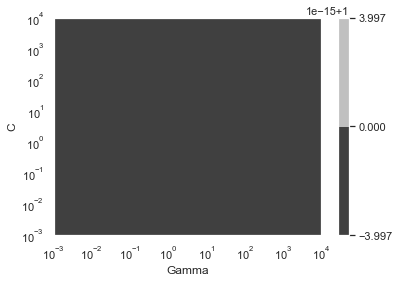

In [156]:
def plot_param_search_rbf(X_train, y_train, X_test, y_test, Cs, gammas):
    def compute_accuracy(C, gamma):
        clf = SVC(kernel='rbf', C=C, gamma=gamma)
        clf.fit(X_train, y_train)
        return clf.score(X_test, y_test)

    Cs = np.power(10, np.linspace(-3, 4, num=20, endpoint=True))
    gammas = np.power(10, np.linspace(-3, 4, num=20, endpoint=True))

    C_mesh, gamma_mesh = np.meshgrid(Cs, gammas)
    Z = np.zeros(C_mesh.shape)
    for i in range(len(gammas)):
        for j in range(len(Cs)):
            Z[i, j] = compute_accuracy(C_mesh[i, j], gamma_mesh[i, j])

    fig, ax = plt.subplots()
    plt.contourf(gamma_mesh, C_mesh, Z, 50, cmap='gray')
    plt.colorbar()
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Gamma')
    ax.set_ylabel('C')
    plt.show()

Cs = np.power(10, np.linspace(-3, 4, num=20, endpoint=True))
gammas = np.power(10, np.linspace(-3, 4, num=20, endpoint=True))
plot_param_search_rbf(X_train, y_train, X_test, y_test, Cs, gammas)

***Reference***
1. imbalance data 

https://towardsdatascience.com/how-to-deal-with-imbalanced-data-34ab7db9b100

should upsample the data (<10k), check performance matrics

https://stats.stackexchange.com/questions/122095/does-support-vector-machine-handle-imbalanced-dataset

https://stats.stackexchange.com/questions/94295/svm-for-unbalanced-data

class weighted SVM

https://scikit-learn.org/stable/auto_examples/svm/plot_separating_hyperplane_unbalanced.html

   
2. change datetime type into integers 

https://www.geeksforgeeks.org/python-pandas-timestamp-toordinal/

3. supervised clustering 

https://stats.stackexchange.com/questions/37587/supervised-clustering-or-classification

4. kmeans normalization

https://datascience.stackexchange.com/questions/6715/is-it-necessary-to-standardize-your-data-before-clustering

5. find best k for kmeans

https://medium.com/analytics-vidhya/how-to-determine-the-optimal-k-for-k-means-708505d204eb

6.

In [ ]:
# # time series prediction
# from statsmodels.tsa.ar_model import AR # train autoregression
# model = AR(train)
# model_fit = model.fit()
# window = model_fit.k_ar
# coef = model_fit.params
# # walk forward over time steps in test
# history = train[len(train)-window:]
# history = [history[i] for i in range(len(history))] predictions = list()
# for t in range(len(test)):
# length = len(history)
# lag = [history[i] for i in range(length-window,length)] yhat = coef[0]
# for d in range(window):
#         yhat += coef[d+1] * lag[window-d-1]
#     predictions.append(yhat)
# error = mean_squared_error(test, predictions) print(’Test MSE: %.3f’ % error)
# print(’Test RMSE: %.3f’ % math.sqrt(error))